In [14]:
import numpy as np
import pandas as pd

%pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

%pip install sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import randint
import gc

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Loading Data

#### Taxi

In [138]:
taxi_trip_df = pd.read_parquet('yellow_tripdata_2024-12.parquet')

#### For-Hire Vehicles

In [83]:
fhv_trip_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2024-12.parquet')

#### Bus

In [17]:
bus_ridership_df = pd.read_csv('MTA_Bus_Hourly_Ridership__2020-2024_20250415.csv')

#### Subway

In [18]:
subway_ridership_df = pd.read_csv('MTA_Subway_Hourly_Ridership__2020-2024_20250415.csv')

#### Taxi Zone

In [77]:
taxi_zone_df = pd.read_csv('https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv')

#### Permitted Events (Historical & Current)

In [20]:
# Obtaining Url with SoQL Queries

permitted_events_historical_url = (
    "https://data.cityofnewyork.us/resource/bkfu-528j.json?" #json file
    "$limit=3000&" #limit
    "$where=start_date_time%20%3E%3D%20%272024-12-01T00:00:00%27" #start_date_time in Dec 2024
    "%20AND%20start_date_time%20%3C%20%272025-01-01T00:00:00%27"
    )

# Read JSON

permitted_events_historical_df = pd.read_json(permitted_events_historical_url)


# Current
permitted_events_current_df = pd.read_json('https://data.cityofnewyork.us/resource/tvpp-9vvx.json?$limit=2000')

# Data Aggreration

## Data Manipulation

### FHV DF

In [ ]:
# filter only December 2024
fhv_trip_df = fhv_trip_df.loc[
    (fhv_trip_df['request_datetime'].dt.year == 2024) &
    (fhv_trip_df['request_datetime'].dt.month == 12)
    ]

fhv_trip_df.head(10)

In [84]:
fhv_trip_df.head(10)

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B03404,B03404,2024-12-01 00:26:25,2024-12-01 00:28:18,2024-12-01 00:30:18,2024-12-01 00:45:00,81,213,6.160,...,1.24,0.0,0.0,0.0,20.80,N,N,N,N,N
1,HV0003,B03404,B03404,2024-12-01 00:43:16,2024-12-01 00:46:46,2024-12-01 00:47:39,2024-12-01 00:55:03,213,213,1.810,...,0.95,0.0,0.0,0.0,10.62,N,N,N,N,N
2,HV0003,B03404,B03404,2024-12-01 00:02:09,2024-12-01 00:07:28,2024-12-01 00:09:29,2024-12-01 00:20:48,221,221,1.460,...,0.99,0.0,0.0,0.0,9.59,Y,N,N,N,N
3,HV0003,B03404,B03404,2024-12-01 00:20:28,2024-12-01 00:27:04,2024-12-01 00:29:05,2024-12-01 00:35:57,245,245,1.830,...,1.07,0.0,0.0,0.0,8.00,N,N,N,N,N
4,HV0003,B03404,B03404,2024-12-01 00:32:23,2024-12-01 00:35:52,2024-12-01 00:36:43,2024-12-01 01:05:17,245,109,9.290,...,3.86,0.0,0.0,0.0,30.79,N,N,N,N,N
5,HV0003,B03404,B03404,2024-12-01 00:07:55,2024-12-01 00:11:20,2024-12-01 00:11:29,2024-12-01 00:15:25,89,89,0.660,...,0.78,0.0,0.0,0.0,5.39,N,N,N,N,N
6,HV0003,B03404,B03404,2024-12-01 00:16:48,2024-12-01 00:21:08,2024-12-01 00:21:53,2024-12-01 00:25:22,89,89,0.470,...,0.79,0.0,0.0,5.0,5.39,N,N,N,N,N
7,HV0003,B03404,B03404,2024-12-01 00:46:41,2024-12-01 00:47:08,2024-12-01 00:47:47,2024-12-01 01:13:55,189,91,5.660,...,2.53,0.0,0.0,0.0,22.93,N,N,N,N,N
8,HV0005,B03406,None,2024-12-01 00:14:47,NaT,2024-12-01 00:20:11,2024-12-01 00:28:45,112,255,1.395,...,0.65,0.0,0.0,0.0,7.45,N,N,N,N,Y
9,HV0005,B03406,None,2024-12-01 00:26:21,NaT,2024-12-01 00:33:49,2024-12-01 00:39:07,255,80,0.931,...,0.57,0.0,0.0,2.0,5.47,N,N,N,N,Y


In [85]:
fhs_code = {'HV0002':'Juno', 'HV0003':'Uber', 'HV0004':'Via', 'HV0005':'Lyft'}

# Create a new column for For-Hire Services
fhv_trip_df['service_provider'] = fhv_trip_df['hvfhs_license_num'].replace(fhs_code)

# Remove unnecessary columns
fhv_trip_df.drop(columns=['hvfhs_license_num',
                          'dispatching_base_num','originating_base_num',
                          'shared_request_flag','shared_match_flag','access_a_ride_flag',
                          'wav_request_flag','wav_match_flag','DOLocationID','on_scene_datetime','dropoff_datetime','trip_miles','trip_time',
                          'base_passenger_fare','tolls','bcf','sales_tax','tips','driver_pay','airport_fee','congestion_surcharge'
                          ], 
                          inplace=True)

fhv_trip_df.rename(columns={'pickup_datetime':'transit_timestamp',
                            'PULocationID':'LocationID'
                            },
                   inplace=True)

fhv_trip_df.sample(10)

,request_datetime,transit_timestamp,LocationID,service_provider
19947046,2024-12-30 07:30:17,2024-12-30 07:34:05,137,Uber
10748963,2024-12-15 19:50:58,2024-12-15 19:53:34,249,Lyft
19161592,2024-12-28 19:00:05,2024-12-28 19:07:06,100,Uber
20867558,2024-12-31 20:45:19,2024-12-31 20:49:14,68,Uber
2947541,2024-12-05 15:39:07,2024-12-05 15:45:19,97,Uber
1435283,2024-12-03 09:58:05,2024-12-03 10:02:35,141,Uber
636745,2024-12-02 00:27:23,2024-12-02 00:31:44,7,Lyft
2032222,2024-12-04 09:07:24,2024-12-04 09:15:18,40,Lyft
4148083,2024-12-07 00:42:27,2024-12-07 00:46:32,102,Uber
9653476,2024-12-14 13:38:46,2024-12-14 13:43:07,256,Uber


In [86]:
fhv_trip_df['waiting_time'] = fhv_trip_df['transit_timestamp'].dt.minute - fhv_trip_df['request_datetime'].dt.minute

fhv_trip_df.head(10)

,request_datetime,transit_timestamp,LocationID,service_provider,waiting_time
0,2024-12-01 00:26:25,2024-12-01 00:30:18,81,Uber,4
1,2024-12-01 00:43:16,2024-12-01 00:47:39,213,Uber,4
2,2024-12-01 00:02:09,2024-12-01 00:09:29,221,Uber,7
3,2024-12-01 00:20:28,2024-12-01 00:29:05,245,Uber,9
4,2024-12-01 00:32:23,2024-12-01 00:36:43,245,Uber,4
5,2024-12-01 00:07:55,2024-12-01 00:11:29,89,Uber,4
6,2024-12-01 00:16:48,2024-12-01 00:21:53,89,Uber,5
7,2024-12-01 00:46:41,2024-12-01 00:47:47,189,Uber,1
8,2024-12-01 00:14:47,2024-12-01 00:20:11,112,Lyft,6
9,2024-12-01 00:26:21,2024-12-01 00:33:49,255,Lyft,7


In [87]:
print(fhv_trip_df['waiting_time'].isnull().sum() / len(fhv_trip_df)* 100)

0.0


In [88]:
fhv_trip_df.drop(columns=['request_datetime'],inplace=True)

In [89]:
fhv_trip_df.head(10)

,transit_timestamp,LocationID,service_provider,waiting_time
0,2024-12-01 00:30:18,81,Uber,4
1,2024-12-01 00:47:39,213,Uber,4
2,2024-12-01 00:09:29,221,Uber,7
3,2024-12-01 00:29:05,245,Uber,9
4,2024-12-01 00:36:43,245,Uber,4
5,2024-12-01 00:11:29,89,Uber,4
6,2024-12-01 00:21:53,89,Uber,5
7,2024-12-01 00:47:47,189,Uber,1
8,2024-12-01 00:20:11,112,Lyft,6
9,2024-12-01 00:33:49,255,Lyft,7


### Taxi DF

In [139]:
#filter for only December 2025
taxi_trip_df = taxi_trip_df.loc[
    (taxi_trip_df['tpep_pickup_datetime'].dt.year == 2024) &
    (taxi_trip_df['tpep_pickup_datetime'].dt.month == 12)
    ]

taxi_trip_df.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-12-01 00:12:27,2024-12-01 00:31:12,1.0,9.76,1.0,N,138,33,1,38.0,6.0,0.5,4.72,0.00,1.0,51.97,0.0,1.75
2,2,2024-12-01 00:50:35,2024-12-01 01:24:46,4.0,20.07,2.0,N,132,236,2,70.0,0.0,0.5,0.00,6.94,1.0,82.69,2.5,1.75
3,2,2024-12-01 00:18:16,2024-12-01 00:33:16,3.0,2.34,1.0,N,142,186,1,15.6,1.0,0.5,4.12,0.00,1.0,24.72,2.5,0.00
4,2,2024-12-01 00:56:13,2024-12-01 01:18:25,1.0,5.05,1.0,N,107,80,1,26.8,1.0,0.5,5.00,0.00,1.0,36.80,2.5,0.00
5,1,2024-12-01 00:21:17,2024-12-01 00:37:22,1.0,4.30,1.0,N,249,141,1,20.5,3.5,0.5,5.10,0.00,1.0,30.60,2.5,0.00
6,2,2024-12-01 00:04:53,2024-12-01 00:31:03,1.0,7.66,1.0,N,186,52,1,35.2,1.0,0.5,8.04,0.00,1.0,48.24,2.5,0.00
7,1,2024-12-01 00:15:28,2024-12-01 00:20:13,1.0,0.30,1.0,N,148,148,3,5.8,3.5,0.5,0.00,0.00,1.0,10.80,2.5,0.00
8,1,2024-12-01 00:38:54,2024-12-01 01:03:46,1.0,9.40,1.0,N,234,244,1,39.4,3.5,0.5,0.00,0.00,1.0,44.40,2.5,0.00
9,2,2024-12-01 00:00:21,2024-12-01 00:05:27,2.0,0.72,1.0,N,211,231,1,7.2,1.0,0.5,2.44,0.00,1.0,14.64,2.5,0.00
10,2,2024-12-01 00:07:13,2024-12-01 00:20:57,2.0,3.54,1.0,N,231,48,1,17.7,1.0,0.5,4.54,0.00,1.0,27.24,2.5,0.00


In [140]:
taxi_trip_df.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-12-01 00:12:27,2024-12-01 00:31:12,1.0,9.76,1.0,N,138,33,1,38.0,6.0,0.5,4.72,0.00,1.0,51.97,0.0,1.75
2,2,2024-12-01 00:50:35,2024-12-01 01:24:46,4.0,20.07,2.0,N,132,236,2,70.0,0.0,0.5,0.00,6.94,1.0,82.69,2.5,1.75
3,2,2024-12-01 00:18:16,2024-12-01 00:33:16,3.0,2.34,1.0,N,142,186,1,15.6,1.0,0.5,4.12,0.00,1.0,24.72,2.5,0.00
4,2,2024-12-01 00:56:13,2024-12-01 01:18:25,1.0,5.05,1.0,N,107,80,1,26.8,1.0,0.5,5.00,0.00,1.0,36.80,2.5,0.00
5,1,2024-12-01 00:21:17,2024-12-01 00:37:22,1.0,4.30,1.0,N,249,141,1,20.5,3.5,0.5,5.10,0.00,1.0,30.60,2.5,0.00
6,2,2024-12-01 00:04:53,2024-12-01 00:31:03,1.0,7.66,1.0,N,186,52,1,35.2,1.0,0.5,8.04,0.00,1.0,48.24,2.5,0.00
7,1,2024-12-01 00:15:28,2024-12-01 00:20:13,1.0,0.30,1.0,N,148,148,3,5.8,3.5,0.5,0.00,0.00,1.0,10.80,2.5,0.00
8,1,2024-12-01 00:38:54,2024-12-01 01:03:46,1.0,9.40,1.0,N,234,244,1,39.4,3.5,0.5,0.00,0.00,1.0,44.40,2.5,0.00
9,2,2024-12-01 00:00:21,2024-12-01 00:05:27,2.0,0.72,1.0,N,211,231,1,7.2,1.0,0.5,2.44,0.00,1.0,14.64,2.5,0.00
10,2,2024-12-01 00:07:13,2024-12-01 00:20:57,2.0,3.54,1.0,N,231,48,1,17.7,1.0,0.5,4.54,0.00,1.0,27.24,2.5,0.00


In [141]:

taxi_trip_df['service_provider'] = 'Taxi' #Purpose: To fill in the 'service_provider' before joining the FHV DataFrame
taxi_trip_df['waiting_time'] = 0.0 #Purpose: To fill in missing values before joining with the FHV DataFrame

taxi_trip_df.rename(columns=
                    {'tpep_pickup_datetime':'transit_timestamp',
                     'PULocationID':'LocationID'
                     }, 
                    inplace=True)

taxi_trip_df.drop(columns=['VendorID','passenger_count','store_and_fwd_flag',
                           'Airport_fee','improvement_surcharge','tolls_amount','tip_amount','mta_tax',
                           'payment_type','DOLocationID','RatecodeID','trip_distance','tpep_dropoff_datetime',
                           'fare_amount','total_amount','extra','congestion_surcharge'
                           ], inplace=True)

taxi_trip_df.head(10)                        

,transit_timestamp,LocationID,service_provider,waiting_time
0,2024-12-01 00:12:27,138,Taxi,0.0
2,2024-12-01 00:50:35,132,Taxi,0.0
3,2024-12-01 00:18:16,142,Taxi,0.0
4,2024-12-01 00:56:13,107,Taxi,0.0
5,2024-12-01 00:21:17,249,Taxi,0.0
6,2024-12-01 00:04:53,186,Taxi,0.0
7,2024-12-01 00:15:28,148,Taxi,0.0
8,2024-12-01 00:38:54,234,Taxi,0.0
9,2024-12-01 00:00:21,211,Taxi,0.0
10,2024-12-01 00:07:13,231,Taxi,0.0


In [142]:
taxi_trip_df.dtypes

transit_timestamp    datetime64[us]
LocationID                    int32
service_provider             object
waiting_time                float64
dtype: object

### Bus DF

In [32]:
bus_ridership_df.sample(10)

,transit_timestamp,bus_route,ridership,payment_method,fare_class_category,transfers
3582361,12/16/2024 08:00:00 AM,Q08,0,omny,OMNY - Fair Fare,0
3286307,12/15/2024 02:00:00 AM,B1,1,metrocard,Metrocard - Full Fare,1
304278,12/02/2024 07:00:00 AM,Q97,0,omny,Metrocard - Seniors & Disability,0
1156426,12/05/2024 10:00:00 PM,BX15,4,metrocard,Metrocard - Other,0
6390642,12/28/2024 09:00:00 AM,Q42,0,omny,Metrocard - Unlimited 7-Day,0
1767387,12/08/2024 01:00:00 PM,S55,0,metrocard,Metrocard - Fair Fare,0
3522388,12/16/2024 02:00:00 AM,BX17,0,omny,Metrocard - Students,0
5292155,12/23/2024 04:00:00 PM,B91A,0,omny,Metrocard - Unlimited 7-Day,0
5795746,12/25/2024 08:00:00 PM,S57,0,omny,OMNY - Students,0
6417480,12/28/2024 12:00:00 PM,B7,6,omny,OMNY - Students,0


In [33]:
print(bus_ridership_df.columns)

Index(['transit_timestamp', 'bus_route', 'ridership', 'payment_method',
       'fare_class_category', 'transfers'],
      dtype='object')


Data Aggregation

In [34]:
bus_ridership_df.rename(columns={
    'ridership':'number_of_rides'
    },inplace=True)

bus_ridership_df['service_provider'] = 'bus'

# Drop unnecessary columns
bus_ridership_df.drop(columns=['payment_method','fare_class_category','transfers'],inplace=True)

# Group by bus_route only, remove unnecessary columns, and aggregate the number_of_rides
bus_ridership_df = bus_ridership_df.groupby(['transit_timestamp', 'bus_route'], as_index=False).agg({'number_of_rides': 'sum'})

In [35]:
bus_ridership_df.sample(10)

,transit_timestamp,bus_route,number_of_rides
176417,12/19/2024 02:00:00 PM,Q39,287
257023,12/27/2024 06:00:00 AM,Q5,287
286029,12/30/2024 06:00:00 AM,BX3,155
88614,12/10/2024 02:00:00 AM,S59,0
267347,12/28/2024 07:00:00 AM,B65,56
215260,12/23/2024 02:00:00 PM,Q11,96
3144,12/01/2024 04:00:00 PM,QM6,16
117466,12/13/2024 02:00:00 AM,B25,2
183435,12/19/2024 11:00:00 AM,X10,0
173570,12/18/2024 11:00:00 AM,Q28,315


In [36]:
bus_ridership_df.loc[bus_ridership_df['number_of_rides'] > 0]

,transit_timestamp,bus_route,number_of_rides
0,12/01/2024 01:00:00 AM,B1,9
3,12/01/2024 01:00:00 AM,B103,16
5,12/01/2024 01:00:00 AM,B11,1
7,12/01/2024 01:00:00 AM,B12,8
8,12/01/2024 01:00:00 AM,B13,3
...,...,...,...
301275,12/31/2024 12:00:00 PM,SIM34,48
301277,12/31/2024 12:00:00 PM,SIM3C,46
301279,12/31/2024 12:00:00 PM,SIM4C,75
301304,12/31/2024 12:00:00 PM,X27,52


Convert data type for 'transit_timestamp' from 'object' to 'datetime64[us]'

In [37]:
# Convert to datetime[us]
bus_ridership_df['transit_timestamp'] = pd.to_datetime(bus_ridership_df['transit_timestamp']).astype('datetime64[us]')

#Add 'service_provider' column for joining with other tables, based on this common key
bus_ridership_df['service_provider'] = 'bus'

In [38]:
bus_ridership_df.sample(10)

,transit_timestamp,bus_route,number_of_rides,service_provider
88258,2024-12-10 13:00:00,SIM9,0,bus
254291,2024-12-27 14:00:00,SIM31,0,bus
281352,2024-12-29 00:00:00,Q97,0,bus
96892,2024-12-10 12:00:00,BX28,196,bus
285946,2024-12-30 06:00:00,B25,66,bus
256705,2024-12-27 17:00:00,S94,97,bus
24447,2024-12-03 07:00:00,M100,514,bus
30964,2024-12-04 03:00:00,M8,0,bus
164899,2024-12-17 12:00:00,B93,0,bus
148430,2024-12-16 04:00:00,Q103,0,bus


In [39]:
bus_ridership_df.dtypes

transit_timestamp    datetime64[us]
bus_route                    object
number_of_rides               int64
service_provider             object
dtype: object

### Subway DF

In [40]:
subway_ridership_df.head(10)

,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,Georeference
0,12/01/2024 12:00:00 AM,subway,185,Liberty Av (C),Brooklyn,metrocard,Metrocard - Other,1,0,40.674540,-73.896545,POINT (-73.896545 40.67454)
1,12/01/2024 12:00:00 AM,subway,192,Rockaway Blvd (A),Queens,metrocard,Metrocard - Unlimited 30-Day,3,0,40.680428,-73.843860,POINT (-73.84386 40.680428)
2,12/01/2024 12:00:00 AM,subway,277,"7 Av (E,B,D)",Manhattan,omny,OMNY - Full Fare,155,1,40.762863,-73.981636,POINT (-73.981636 40.762863)
3,12/01/2024 12:00:00 AM,subway,59,9 Av (D),Brooklyn,omny,OMNY - Full Fare,12,2,40.646294,-73.994320,POINT (-73.99432 40.646294)
4,12/01/2024 12:00:00 AM,subway,314,66 St-Lincoln Center (1),Manhattan,metrocard,Metrocard - Seniors & Disability,3,0,40.773440,-73.982210,POINT (-73.98221 40.77344)
5,12/01/2024 12:00:00 AM,subway,283,Greenpoint Av (G),Brooklyn,omny,OMNY - Full Fare,42,1,40.731354,-73.954450,POINT (-73.95445 40.731354)
6,12/01/2024 12:00:00 AM,subway,283,Greenpoint Av (G),Brooklyn,omny,OMNY - Students,3,0,40.731354,-73.954450,POINT (-73.95445 40.731354)
7,12/01/2024 12:00:00 AM,subway,45,Beverley Rd (Q),Brooklyn,metrocard,Metrocard - Seniors & Disability,1,0,40.644030,-73.964490,POINT (-73.96449 40.64403)
8,12/01/2024 12:00:00 AM,subway,456,61 St-Woodside (7),Queens,omny,OMNY - Students,3,0,40.745630,-73.902985,POINT (-73.902985 40.74563)
9,12/01/2024 12:00:00 AM,subway,319,28 St (1),Manhattan,omny,OMNY - Full Fare,69,0,40.747215,-73.993360,POINT (-73.99336 40.747215)


In [41]:
subway_ridership_df.dtypes

transit_timestamp       object
transit_mode            object
station_complex_id      object
station_complex         object
borough                 object
payment_method          object
fare_class_category     object
ridership                int64
transfers                int64
latitude               float64
longitude              float64
Georeference            object
dtype: object

In [42]:
subway_ridership_df.rename(columns={
    'ridership':'demand',
    'transit_mode':'service_provider',
    'borough':'Borough'
    },inplace=True)

# Convert to datetime[us] (microsecond precision)
subway_ridership_df['transit_timestamp'] = subway_ridership_df['transit_timestamp'].astype('datetime64[us]')

# Drop unnecessary columns
subway_ridership_df.drop(columns=['station_complex_id','payment_method','station_complex',
                                  'fare_class_category','transfers','Georeference',
                                  'latitude','longitude'],
                                  inplace=True)

In [43]:
subway_ridership_df.sample(10)

,transit_timestamp,service_provider,Borough,demand
1802486,2024-12-23 14:00:00,subway,Brooklyn,22
1909198,2024-12-24 21:00:00,subway,Queens,1
2001720,2024-12-26 05:00:00,subway,Bronx,11
272553,2024-12-04 11:00:00,subway,Manhattan,120
1083578,2024-12-14 13:00:00,subway,Bronx,87
585030,2024-12-08 09:00:00,subway,Manhattan,7
1043055,2024-12-13 23:00:00,subway,Manhattan,9
1257624,2024-12-16 17:00:00,subway,Queens,14
2110439,2024-12-27 14:00:00,subway,Brooklyn,13
155065,2024-12-02 23:00:00,subway,Manhattan,5


### Permitted Events DF

In [44]:
permitted_events_historical_df.sample(5)

,event_id,event_name,start_date_time,end_date_time,event_agency,event_type,event_borough,event_location,street_closure_type,community_board,police_precinct,event_street_side
118,808346,Lawn Closure - Cedar Hill Bowl,2024-12-01 00:01:00,2024-12-01 23:59:00,Parks Department,Special Event,Manhattan,Central Park: Cedar Hill,N/A,"64,","22,",NaN
231,809501,Lawn Closure - W93rd Playground Lawn,2024-12-01 00:01:00,2024-12-01 23:59:00,Parks Department,Special Event,Manhattan,Central Park: Wild West Playground Lawn,N/A,"64,","22,",NaN
912,812308,Soccer -Regulation,2024-12-01 08:00:00,2024-12-01 17:00:00,Parks Department,Sport - Youth,Bronx,"Williamsbridge Oval: Soccer-01 ,Van Cortlandt ...",N/A,"07, 26,","50, 52,",NaN
2398,811504,Baseball - 12 and Under (Little League),2024-12-01 11:00:00,2024-12-01 17:00:00,Parks Department,Sport - Youth,Brooklyn,Homecrest Playground: Multi Purpose Play Area-01,N/A,"15,","61,",NaN
988,746602,GallopNYC Therapeutic Horsemanship at Prospect...,2024-12-01 08:00:00,2024-12-01 17:00:00,Parks Department,Special Event,Brooklyn,Parade Ground: Bowling Green Lawn,N/A,"14,","70,",NaN


In [45]:
event_counts_by_borough_df = permitted_events_historical_df.groupby(['event_borough','start_date_time','end_date_time']).size().reset_index(name='number_of_events')

event_counts_by_borough_df.head(10)


,event_borough,start_date_time,end_date_time,number_of_events
0,Bronx,2024-12-01 08:00:00,2024-12-01 17:00:00,17
1,Bronx,2024-12-01 08:00:00,2024-12-01 19:00:00,17
2,Bronx,2024-12-01 08:00:00,2024-12-01 22:00:00,17
3,Bronx,2024-12-01 10:00:00,2024-12-01 16:00:00,1
4,Bronx,2024-12-01 12:00:00,2024-12-01 17:00:00,16
5,Bronx,2024-12-01 13:00:00,2024-12-01 14:00:00,1
6,Bronx,2024-12-01 14:00:00,2024-12-01 20:00:00,10
7,Bronx,2024-12-01 14:00:00,2024-12-01 22:00:00,15
8,Brooklyn,2024-12-01 07:00:00,2024-12-01 20:00:00,17
9,Brooklyn,2024-12-01 08:00:00,2024-12-01 10:00:00,12


In [108]:
event_counts_by_borough_df['start_date'] = event_counts_by_borough_df['start_date_time'].dt.date
event_counts_by_borough_df['end_date'] = event_counts_by_borough_df['end_date_time'].dt.date

event_counts_by_borough_df['start_hour'] = event_counts_by_borough_df['start_date_time'].dt.hour
event_counts_by_borough_df['end_hour'] = event_counts_by_borough_df['end_date_time'].dt.hour

event_counts_by_borough_df.drop(columns=['start_date_time','end_date_time'],inplace=True)

event_counts_by_borough_df.sample(10)


,event_borough,number_of_events,start_date,end_date,start_hour,end_hour
129,Queens,17,2024-12-01,2024-12-01,13,15
3,Bronx,1,2024-12-01,2024-12-01,10,16
84,Manhattan,7,2024-12-01,2024-12-01,12,22
67,Manhattan,7,2024-12-01,2024-12-01,9,12
75,Manhattan,17,2024-12-01,2024-12-01,10,18
130,Queens,16,2024-12-01,2024-12-01,13,17
131,Queens,16,2024-12-01,2024-12-01,13,18
42,Brooklyn,8,2024-12-01,2024-12-01,13,15
83,Manhattan,32,2024-12-01,2024-12-01,12,16
39,Brooklyn,55,2024-12-01,2024-12-01,12,16


## Creating the Trip DF

In [182]:
trips_df = taxi_trip_df.merge(fhv_trip_df, how='outer', on=[
    'transit_timestamp','service_provider','LocationID', 'waiting_time'
    ])

trips_df.head(10)

# Delete dataframes that are no longer needed to free up memory
#del taxi_trip_df
#del fhv_trip_df
#gc.collect()

,transit_timestamp,LocationID,service_provider,waiting_time
0,2024-12-01,236,Lyft,-56.0
1,2024-12-01,144,Taxi,0.0
2,2024-12-01,7,Uber,-56.0
3,2024-12-01,36,Uber,-58.0
4,2024-12-01,37,Uber,-56.0
5,2024-12-01,37,Uber,-54.0
6,2024-12-01,48,Uber,-57.0
7,2024-12-01,48,Uber,-54.0
8,2024-12-01,56,Uber,-54.0
9,2024-12-01,71,Uber,-57.0


In [183]:
len(trips_df)

24737188

### Joining Trip DF and Taxi Zone DF

In [184]:
trips_df = trips_df.merge(taxi_zone_df, on='LocationID',how='left')

In [189]:
trips_df.sample(10)

,transit_timestamp,LocationID,service_provider,waiting_time,Borough,Zone,service_zone
10009451,2024-12-12 23:30:05,60,Lyft,5.0,Bronx,Crotona Park East,Boro Zone
3884068,2024-12-05 23:31:22,95,Uber,4.0,Queens,Forest Hills,Boro Zone
6644730,2024-12-08 22:20:44,47,Uber,5.0,Bronx,Claremont/Bathgate,Boro Zone
9569880,2024-12-12 14:58:38,98,Uber,5.0,Queens,Fresh Meadows,Boro Zone
2092918,2024-12-03 21:01:34,124,Uber,-52.0,Queens,Howard Beach,Boro Zone
11185487,2024-12-14 03:56:32,107,Uber,3.0,Manhattan,Gramercy,Yellow Zone
7366696,2024-12-09 21:34:48,246,Uber,12.0,Manhattan,West Chelsea/Hudson Yards,Yellow Zone
1620059,2024-12-03 09:16:55,95,Uber,2.0,Queens,Forest Hills,Boro Zone
1679787,2024-12-03 10:52:32,28,Lyft,2.0,Queens,Briarwood/Jamaica Hills,Boro Zone
10579641,2024-12-13 16:26:48,220,Uber,3.0,Bronx,Spuyten Duyvil/Kingsbridge,Boro Zone


# Data Exploration

### Trips 

<Axes: xlabel='service_provider', ylabel='Count'>

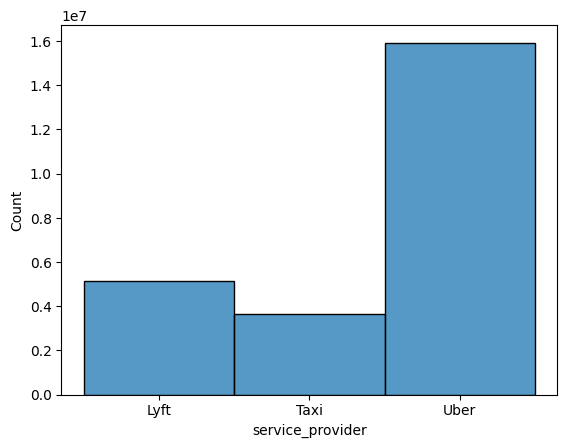

In [147]:
sns.histplot(x=trips_df['service_provider'])

<Axes: xlabel='transit_timestamp', ylabel='Count'>

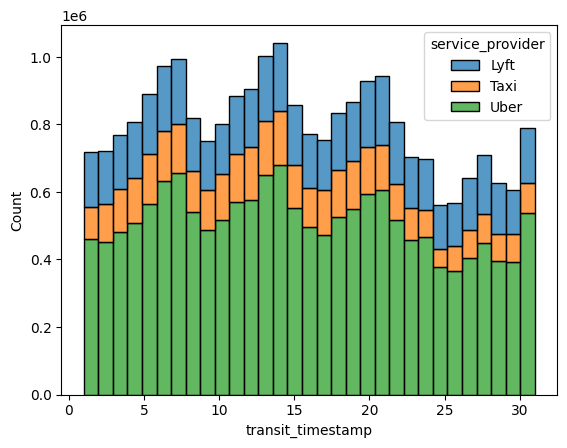

In [148]:
sns.histplot(data=trips_df, x=trips_df['transit_timestamp'].dt.day, bins=31, hue='service_provider', multiple='stack')

Text(0, 0.5, 'Demand')

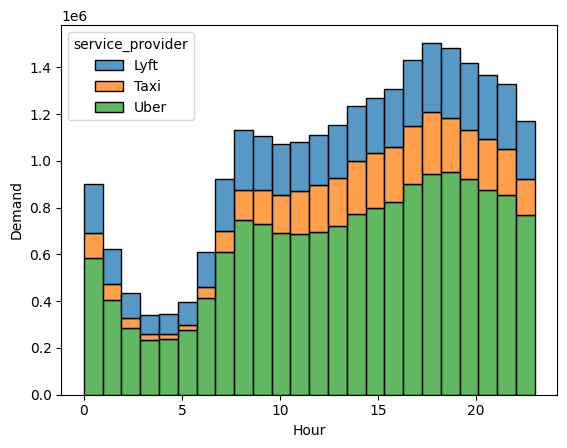

In [149]:
sns.histplot(data=trips_df, x=trips_df['transit_timestamp'].dt.hour, bins=24, hue='service_provider', multiple='stack')

plt.xlabel('Hour')
plt.ylabel('Demand')

<Axes: xlabel='Borough', ylabel='Count'>

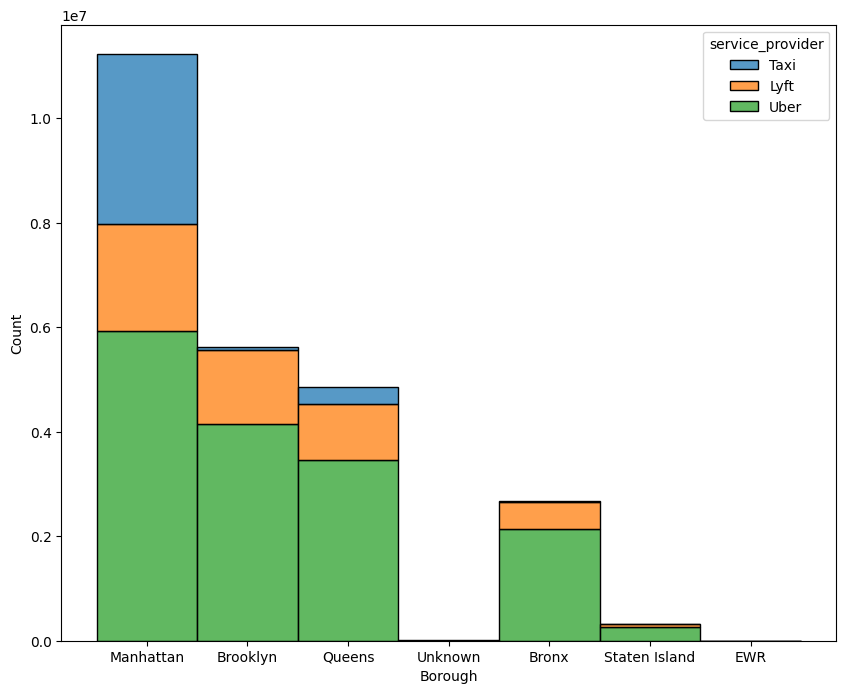

In [53]:
plt.figure(figsize=(10,8))
sns.histplot(data=trips_df, x='Borough', hue='service_provider', bins=200, multiple='stack')

### Permitted Events

<Axes: xlabel='event_borough', ylabel='Count'>

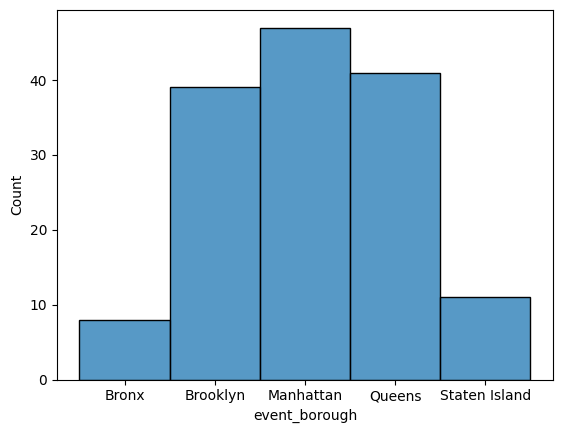

In [54]:
sns.histplot(data=event_counts_by_borough_df, x=event_counts_by_borough_df['event_borough'])

Text(0.5, 1.0, 'Number of Events in a Day (per Borough)')

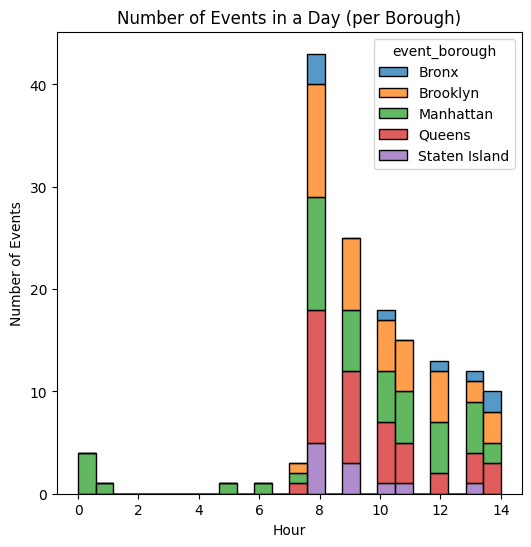

In [55]:
plt.figure(figsize=(6,6))
sns.histplot(data=event_counts_by_borough_df, x=event_counts_by_borough_df['start_date_time'].dt.hour, hue='event_borough', multiple='stack', bins=24)

plt.xlabel('Hour')
plt.ylabel('Number of Events')
plt.title('Number of Events in a Day (per Borough)')

Text(0.5, 1.0, 'Number of Events in a Week (per Borough)')

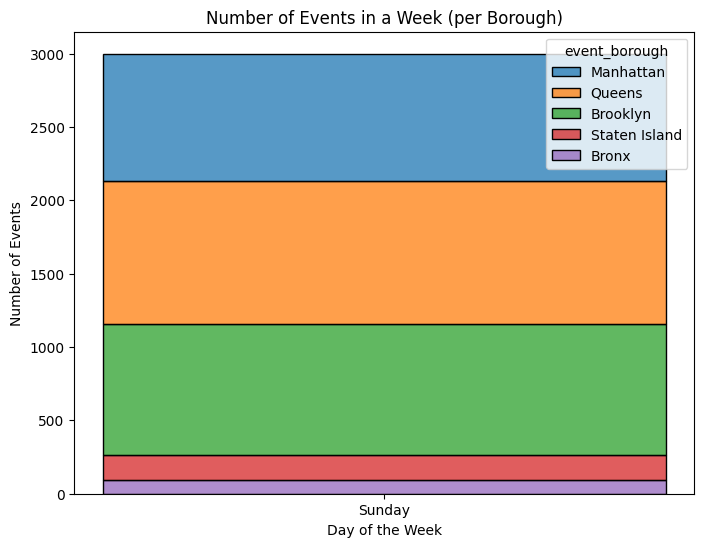

In [56]:
plt.figure(figsize=(8,6))
sns.histplot(data=permitted_events_historical_df, x=permitted_events_historical_df['start_date_time'].dt.day_name(), hue='event_borough', multiple='stack')

plt.xlabel('Day of the Week')
plt.ylabel('Number of Events')
plt.title('Number of Events in a Week (per Borough)')

Text(0.5, 1.0, 'Number of Events in a Day (per Borough)')

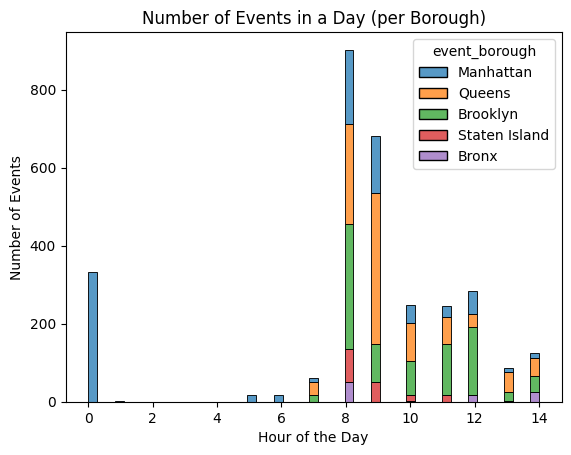

In [57]:
sns.histplot(data=permitted_events_historical_df, x=permitted_events_historical_df['start_date_time'].dt.hour, hue='event_borough', multiple='stack')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Events')
plt.title('Number of Events in a Day (per Borough)')

## Buses & Subways

<Axes: xlabel='bus_route', ylabel='number_of_rides'>

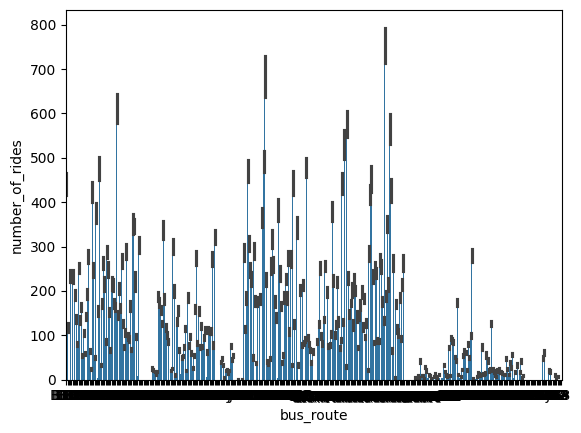

In [58]:
sns.barplot(data=bus_ridership_df, x='bus_route',y='number_of_rides')

# Creating Demand DataFrame

In [177]:
demand_trips_df = trips_df.copy()

#demand_trips_df['date'] = demand_trips_df['transit_timestamp'].dt.date
#demand_trips_df['hour'] = demand_trips_df['transit_timestamp'].dt.hour

#demand_trips_df.drop(columns='transit_timestamp',inplace=True)

#Aggregating data and calculating number of rides
demand_trips_df = demand_trips_df.groupby(['transit_timestamp','service_provider','LocationID','waiting_time']).size().reset_index(name='demand')

In [178]:
demand_trips_df.sample(10)

,transit_timestamp,service_provider,LocationID,waiting_time,demand
3685956,2024-12-05 20:20:59,Uber,231,5.0,1
21802111,2024-12-27 23:56:25,Lyft,41,3.0,1
16708167,2024-12-20 19:45:44,Lyft,95,7.0,1
21972157,2024-12-28 09:43:33,Uber,98,3.0,1
23031120,2024-12-29 20:39:59,Uber,136,2.0,1
11746096,2024-12-14 20:33:16,Lyft,17,8.0,1
16613329,2024-12-20 18:06:05,Uber,68,5.0,1
14312067,2024-12-17 23:48:00,Lyft,166,6.0,1
3709905,2024-12-05 20:48:46,Taxi,237,0.0,1
4964930,2024-12-07 03:52:14,Uber,112,5.0,1


## Exploring Demand DF

Text(0, 0.5, 'Demand')

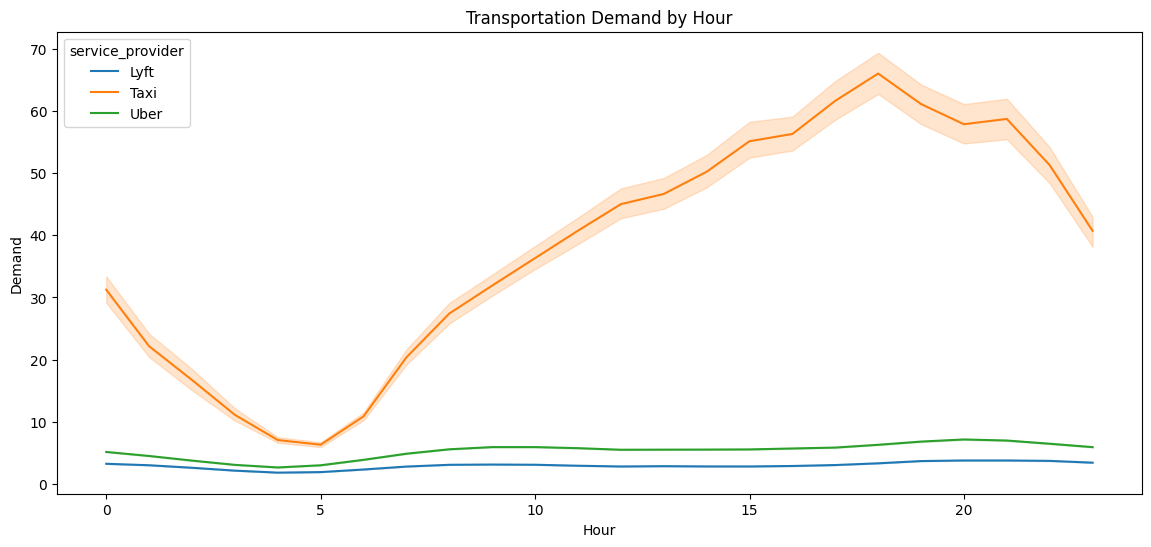

In [152]:
plt.figure(figsize=(14,6))
sns.lineplot(data=demand_trips_df,x='hour',y='demand',hue='service_provider')

plt.title("Transportation Demand by Hour")
plt.xlabel("Hour")
plt.ylabel("Demand")

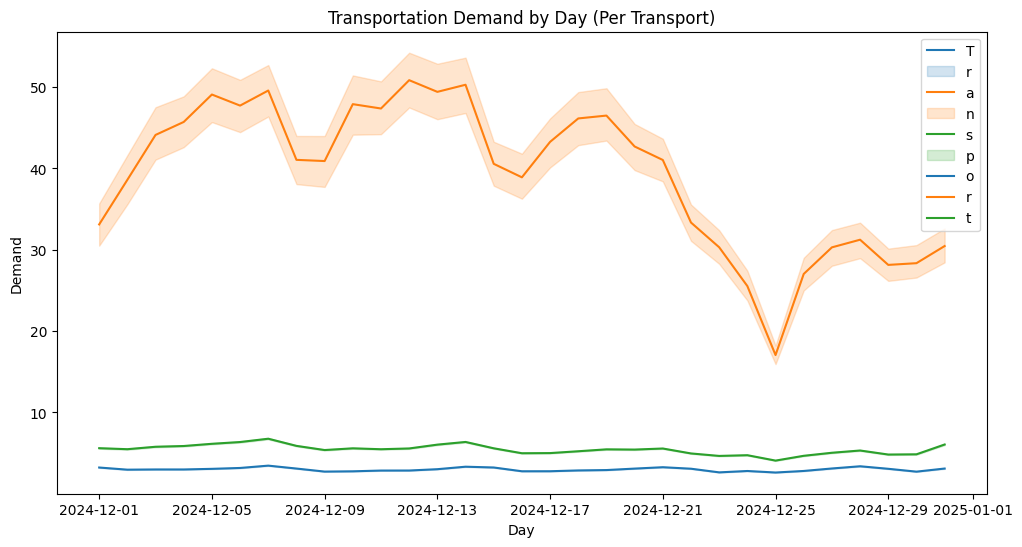

In [153]:
plt.figure(figsize=(12,6))
sns.lineplot(data=demand_trips_df,x='date',y='demand',hue='service_provider')

plt.title("Transportation Demand by Day (Per Transport)")
plt.xlabel("Day")
plt.ylabel("Demand")

#### Check Memory Usage

In [67]:
import sys

for var_name in dir():
    try:
        var_obj = globals()[var_name]
        if isinstance(var_obj, pd.DataFrame):
            mem = var_obj.memory_usage(deep=True).sum() / (1024 ** 3)  # GB
            if mem > 1:
                print(f"{var_name}: {mem:.2f} GB")
    except:
        pass  # skip anything that throws errors


demand_df: 2.09 GB
demand_trips_df: 1.77 GB
fhv_trip_df: 1.67 GB
trips_df: 6.57 GB


# Adding Events Feature

In [163]:
demand_trips_df = demand_trips_df.merge(taxi_zone_df, on='LocationID',how='left')

demand_trips_df.head(10)

,transit_timestamp,service_provider,LocationID,waiting_time,demand,Borough,Zone,service_zone
0,2024-12-01,Lyft,236,-56.0,1,Manhattan,Upper East Side North,Yellow Zone
1,2024-12-01,Taxi,144,0.0,1,Manhattan,Little Italy/NoLiTa,Yellow Zone
2,2024-12-01,Uber,7,-56.0,1,Queens,Astoria,Boro Zone
3,2024-12-01,Uber,36,-58.0,1,Brooklyn,Bushwick North,Boro Zone
4,2024-12-01,Uber,37,-56.0,1,Brooklyn,Bushwick South,Boro Zone
5,2024-12-01,Uber,37,-54.0,1,Brooklyn,Bushwick South,Boro Zone
6,2024-12-01,Uber,48,-57.0,1,Manhattan,Clinton East,Yellow Zone
7,2024-12-01,Uber,48,-54.0,1,Manhattan,Clinton East,Yellow Zone
8,2024-12-01,Uber,56,-54.0,1,Queens,Corona,Boro Zone
9,2024-12-01,Uber,71,-57.0,1,Brooklyn,East Flatbush/Farragut,Boro Zone


In [158]:
# Function to apply row by row
def get_event_count(row):
    matches = event_counts_by_borough_df[
        (event_counts_by_borough_df['event_borough'] == row['Borough']) &
        (event_counts_by_borough_df['start_date'] <= row['date']) &
        (event_counts_by_borough_df['end_date'] >= row['date']) &
        (event_counts_by_borough_df['start_hour'] <= row['hour']) &
        (event_counts_by_borough_df['end_hour'] >= row['hour'])
    ]
    return matches['number_of_events'].sum()  # or .max() if you prefer

# Apply function
demand_trips_df['number_of_events'] = demand_trips_df.apply(get_event_count, axis=1)


KeyboardInterrupt: 

In [ ]:
demand_trips_df.sample(10)

# Adding Weather Feature

## API Call

In [190]:
demand_trips_df['transit_timestamp'] = pd.to_datetime(demand_trips_df['transit_timestamp']).dt.tz_localize('New York')
demand_trips_df['transit_timestamp'] = pd.to_datetime(demand_trips_df['transit_timestamp']).dt.tz_convert('UTC')


In [ ]:
demand_trips_df['transit_timestamp_unix'] = demand_trips_df['transit_timestamp'].astype(int) // 10**9

demand_trips_df.sample(10)

,transit_timestamp,service_provider,LocationID,waiting_time,demand,transit_timestamp_unix
19997158,2024-12-24 22:34:28+00:00,Uber,238,5.0,1,1735079
24370984,2024-12-31 21:48:03+00:00,Uber,193,14.0,1,1735681
20733276,2024-12-26 09:28:46+00:00,Uber,231,0.0,1,1735205
6626020,2024-12-09 00:02:23+00:00,Lyft,138,-54.0,1,1733702
12437703,2024-12-15 14:42:01+00:00,Uber,144,4.0,1,1734273
9400027,2024-12-12 13:05:34+00:00,Uber,102,3.0,1,1734008
5043694,2024-12-07 08:22:53+00:00,Uber,137,2.0,1,1733559
17119202,2024-12-21 08:29:51+00:00,Uber,141,5.0,1,1734769
6332016,2024-12-08 16:05:02+00:00,Uber,166,3.0,1,1733673
3009947,2024-12-05 01:01:51+00:00,Lyft,130,-54.0,1,1733360


In [167]:
sample_timestamps = demand_trips_df['transit_timestamp_unix'].dropna().unique()[:5]  # get first 5 timestamps

print(sample_timestamps)

[1733011 1733012 1733013 1733014 1733015]


In [168]:
import requests
import time

API_key = 'de19b9336dc433a6a2e4e5f1c3fd49d2'
city_id = 5128581  # New York

# For storing results
weather_data = []

# Loop through unique timestamps to avoid duplicate API calls
for unix_time in sample_timestamps:
    url = f"https://history.openweathermap.org/data/2.5/history/city?id={city_id}&type=hour&start={int(unix_time)}&appid={API_key}"

    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        weather_data.append({'timestamp': unix_time, 'weather': data})
    else:
        print(f"Failed to fetch for {unix_time}: {response.status_code}")

    time.sleep(1.2)  # avoid hitting the API too fast (respect rate limits)


/Users/ikmalbasirun/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Failed to fetch for 1733011: 400
Failed to fetch for 1733012: 400
Failed to fetch for 1733013: 400
Failed to fetch for 1733014: 400
Failed to fetch for 1733015: 400


In [ ]:
weather_df = pd.DataFrame(weather_data)